### Import libraries and functions

In [3]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import LabelPowerset

#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.ensemble import VotingClassifier

from collections import Counter
from nltk.tokenize import WordPunctTokenizer
wpt = WordPunctTokenizer()

### Load training and testing data into dataframes

In [4]:
# Load downloaded training dataset to dataframe
df_train = pd.read_csv('train.csv')

# Load downloaded testing dataset to dataframes
df_test_work = pd.read_csv('test.csv')
df_testlabel_work = pd.read_csv('test_labels.csv')

# Remove downloaded testing data that were not labeled
df_test = df_test_work.drop(df_testlabel_work[df_testlabel_work['toxic'] ==-1].index.values)
df_testlabel = df_testlabel_work[df_testlabel_work['toxic'] !=-1]

# Combined downloaded testing comments and testing labels
df_test_full = df_test.merge(df_testlabel)

# Combined downloaded training and testing data into one full data set
df = df_train.append(df_test_full)

### Clean comment text and split data into training and test sets

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [19]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

In [20]:
train, test = train_test_split(df, random_state=424, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(149777,)
(73772,)


## PART 2

### OneVsRestClassifier + Naive Bayes - Multinomial model w/ TfidfVectorizer

In [ ]:
'''

# Tune parameter min_df

min_df = [1,10,20,50,100,200,500]

for num in min_df:
    NB_pipeline_t = Pipeline([
                    ('vect', TfidfVectorizer(min_df=num, ngram_range=(1, 2),stop_words='english')),
                    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

    NB_pipeline_t.fit(X_train, train[categories].values)

    prediction = NB_pipeline_t.predict(X_train)
    
    print('min_df = {}; accuracy = {:.2%}'.format(num, accuracy_score(train[categories].values, prediction)))

'''

In [33]:
NB_pipeline_t = Pipeline([
                    ('vect', TfidfVectorizer(min_df=20, ngram_range=(1, 2),stop_words='english')),
                    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

NB_pipeline_t.fit(X_train, train[categories].values)

prediction_NB = NB_pipeline_t.predict(X_test)   

In [83]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction_NB)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction_NB)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction_NB[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction_NB[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction_NB[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 90.65%
	 hamming_loss = 2.55%

For individual labels:
	 toxic:
	 accuracy= 94.06%
	 precision = 87.71%
	 recall = 44.88%
	 f1 score = 59.38%
	 hamming_loss = 5.94%

	 severe_toxic:
	 accuracy= 99.12%
	 precision = 61.90%
	 recall = 3.96%
	 f1 score = 7.44%
	 hamming_loss = 0.88%

	 obscene:
	 accuracy= 96.56%
	 precision = 91.52%
	 recall = 41.23%
	 f1 score = 56.85%
	 hamming_loss = 3.44%

	 threat:
	 accuracy= 99.67%
	 precision = nan%
	 recall = 0.00%
	 f1 score = nan%
	 hamming_loss = 0.33%

	 insult:
	 accuracy= 96.25%
	 precision = 82.26%
	 recall = 33.32%
	 f1 score = 47.42%
	 hamming_loss = 3.75%

	 identity_hate:
	 accuracy= 99.03%
	 precision = 80.00%
	 recall = 0.56%
	 f1 score = 1.11%
	 hamming_loss = 0.97%



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


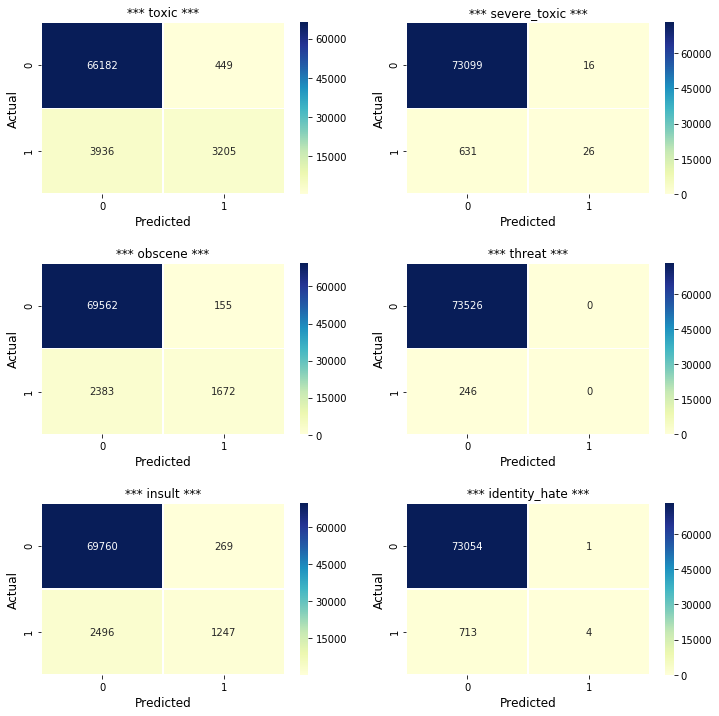

In [84]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1

### OneVsRestClassifier + Linear SVC w/ TfidfVectorizer

In [ ]:
'''

# Tune parameter min_df

min_df = [1,10,20,50,100,200,500]

for num in min_df:
    lsvc_pipeline = Pipeline([
                    ('vect', TfidfVectorizer(min_df=num, ngram_range=(1, 2),stop_words='english')),
                    ('clf', OneVsRestClassifier(LinearSVC()))])

    lsvc_pipeline.fit(X_train, train[categories].values)

    prediction = lsvc_pipeline.predict(X_train)
    
    print('min_df = {}; accuracy = {:.2%}'.format(num, accuracy_score(train[categories].values, prediction)))
    
'''

In [39]:
lsvc_pipeline = Pipeline([
                ('vect', TfidfVectorizer(min_df=1, ngram_range=(1, 2),stop_words='english')),
                ('clf', OneVsRestClassifier(LinearSVC()))])

lsvc_pipeline.fit(X_train, train[categories].values)

prediction_lsvc = lsvc_pipeline.predict(X_test)

In [85]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction_lsvc)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction_lsvc)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction_lsvc[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction_lsvc[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction_lsvc[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 91.22%
	 hamming_loss = 2.07%

For individual labels:
	 toxic:
	 accuracy= 95.19%
	 precision = 80.39%
	 recall = 66.48%
	 f1 score = 72.77%
	 hamming_loss = 4.81%

	 severe_toxic:
	 accuracy= 99.08%
	 precision = 46.43%
	 recall = 23.74%
	 f1 score = 31.42%
	 hamming_loss = 0.92%

	 obscene:
	 accuracy= 97.52%
	 precision = 82.63%
	 recall = 69.57%
	 f1 score = 75.54%
	 hamming_loss = 2.48%

	 threat:
	 accuracy= 99.68%
	 precision = 57.75%
	 recall = 16.67%
	 f1 score = 25.87%
	 hamming_loss = 0.32%

	 insult:
	 accuracy= 96.90%
	 precision = 73.74%
	 recall = 60.41%
	 f1 score = 66.41%
	 hamming_loss = 3.10%

	 identity_hate:
	 accuracy= 99.20%
	 precision = 70.57%
	 recall = 31.10%
	 f1 score = 43.18%
	 hamming_loss = 0.80%



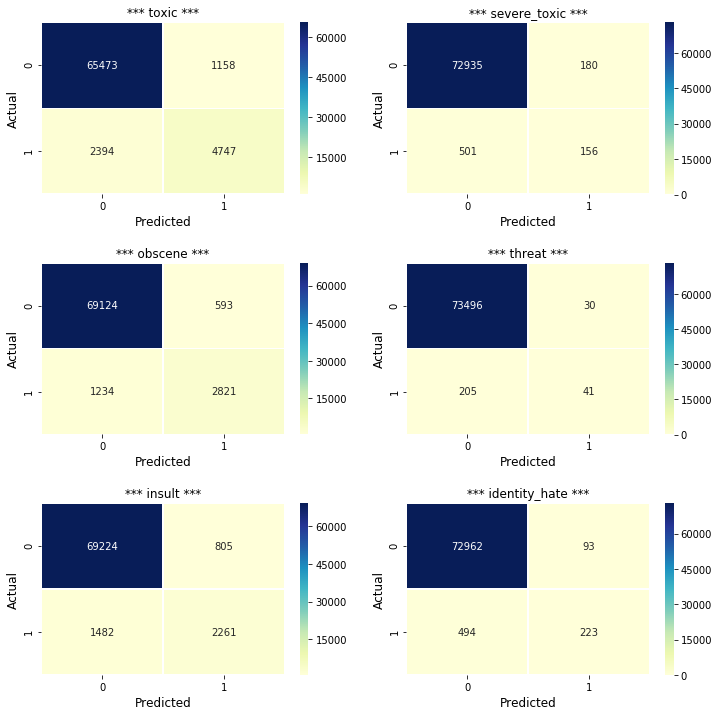

In [86]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1

### OneVsRestClassifier + Logistic Regression w/ TfidfVectorizer

In [ ]:
'''

# Tune parameter min_df

min_df = [1,10,20,50,100,200,500]

for num in min_df:
    lreg_pipeline = Pipeline([
                    ('vect', TfidfVectorizer(min_df=num, ngram_range=(1, 2),stop_words='english')),
                    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag')))])

    lreg_pipeline.fit(X_train, train[categories].values)

    prediction = lreg_pipeline.predict(X_train)
    
    print('min_df = {}; accuracy = {:.2%}'.format(num, accuracy_score(train[categories].values, prediction)))
    
'''

In [36]:
lreg_pipeline = Pipeline([
                ('vect', TfidfVectorizer(min_df=10, ngram_range=(1, 2),stop_words='english')),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag')))])

lreg_pipeline.fit(X_train, train[categories].values)

prediction_lreg = lreg_pipeline.predict(X_test)

In [87]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction_lreg)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction_lreg)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction_lreg[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction_lreg[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction_lreg[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 91.24%
	 hamming_loss = 2.20%

For individual labels:
	 toxic:
	 accuracy= 94.83%
	 precision = 86.92%
	 recall = 54.82%
	 f1 score = 67.24%
	 hamming_loss = 5.17%

	 severe_toxic:
	 accuracy= 99.12%
	 precision = 51.46%
	 recall = 18.72%
	 f1 score = 27.46%
	 hamming_loss = 0.88%

	 obscene:
	 accuracy= 97.28%
	 precision = 88.74%
	 recall = 57.93%
	 f1 score = 70.10%
	 hamming_loss = 2.72%

	 threat:
	 accuracy= 99.68%
	 precision = 63.64%
	 recall = 11.38%
	 f1 score = 19.31%
	 hamming_loss = 0.32%

	 insult:
	 accuracy= 96.73%
	 precision = 80.10%
	 recall = 47.31%
	 f1 score = 59.49%
	 hamming_loss = 3.27%

	 identity_hate:
	 accuracy= 99.16%
	 precision = 75.00%
	 recall = 20.92%
	 f1 score = 32.72%
	 hamming_loss = 0.84%



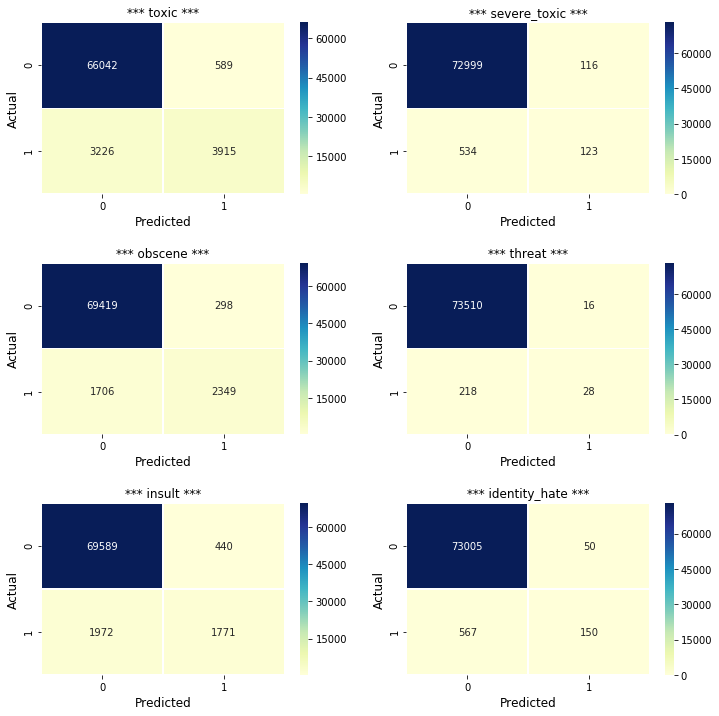

In [88]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1

### Ensemble Method

In [73]:
prediction_ensem = (prediction_NB + prediction_lsvc + prediction_lreg)/3

In [74]:
for num in range(len(prediction_ensem)):
    
    for num2 in range(len(prediction_ensem[num])):
        
        if prediction_ensem[num][num2] > 0.5:
            
            prediction_ensem[num][num2] = 1
            
        else:
            
            prediction_ensem[num][num2] = 0

In [89]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction_ensem)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction_ensem)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction_ensem[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction_ensem[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction_ensem[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 91.28%
	 hamming_loss = 2.16%

For individual labels:
	 toxic:
	 accuracy= 94.98%
	 precision = 86.52%
	 recall = 57.05%
	 f1 score = 68.76%
	 hamming_loss = 5.02%

	 severe_toxic:
	 accuracy= 99.13%
	 precision = 55.23%
	 recall = 14.46%
	 f1 score = 22.92%
	 hamming_loss = 0.87%

	 obscene:
	 accuracy= 97.34%
	 precision = 88.78%
	 recall = 59.14%
	 f1 score = 70.99%
	 hamming_loss = 2.66%

	 threat:
	 accuracy= 99.68%
	 precision = 61.29%
	 recall = 7.72%
	 f1 score = 13.72%
	 hamming_loss = 0.32%

	 insult:
	 accuracy= 96.77%
	 precision = 80.17%
	 recall = 48.38%
	 f1 score = 60.35%
	 hamming_loss = 3.23%

	 identity_hate:
	 accuracy= 99.16%
	 precision = 80.25%
	 recall = 18.13%
	 f1 score = 29.58%
	 hamming_loss = 0.84%



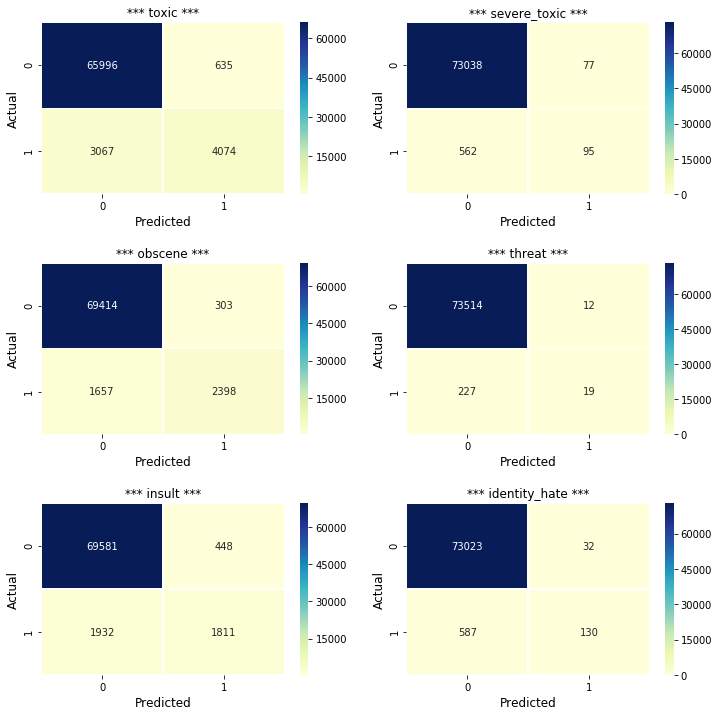

In [90]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1